<a href="https://colab.research.google.com/github/sahasubhajit/Speech-Spoofing-/blob/main/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install jiwer
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from umap import UMAP
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,  PredefinedSplit
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')

In [ ]:
def load_train_data(X_train, y_train):
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return X_train, y_train

def load_validation_data(X_validation, y_validation):
  X_validation = np.array(X_validation)
  y_validation = np.array(y_validation)
  return X_validation, y_validation

def load_test_data(X_test, y_test):
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  return X_test, y_test


class MLModel:
    def __init__(self, model_type, use_supervised_umap=False, mapper=False):
        self.model_type = model_type
        self.use_supervised_umap = use_supervised_umap
        self.mapper = mapper

        if self.use_supervised_umap:
            self.umap = UMAP(n_neighbors=20, n_components=2)
            self.scaler = StandardScaler()
        if model_type == 'SVM':
            self.model = SVC()
            self.param_grid = {'C': [0.1, 1, 5], 'kernel': ['linear', 'rbf']}
        elif model_type == 'RandomForest':
            self.model = RandomForestClassifier()
            self.param_grid = {'n_estimators': [50, 75, 100]}
        elif model_type == 'KNN':
            self.model = KNeighborsClassifier()
            self.param_grid = {'n_neighbors': [3, 5, 7]}
        elif model_type == 'LogisticRegression':
            self.model = LogisticRegression()
            self.param_grid = {'C': [0.1, 1, 5]}
        elif model_type == 'NaiveBayes':
            self.model = GaussianNB()
            self.param_grid = {}
        elif model_type == 'XGBoost':
            self.model = xgb.XGBClassifier()
            self.param_grid = {'max_depth': [5, 10, 15], 'learning_rate': [0.1, 0.01]}
        elif model_type == 'DecisionTree':
            self.model = DecisionTreeClassifier()
            self.param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}
        else:
            print("Unknown model name!")


    def reduce_dimension(self, X_train, y_train, X_val, y_val, algo_name = 'UMAP', supervised = True):
      if algo_name == 'UMAP':
          umap = UMAP(n_neighbors=10, n_components=2)

          if supervised:
              # Train supervised UMAP on labeled data
              mapper = umap.fit(X_train, y_train)
              embedding = mapper.transform(X_val)
          else:
              # Use unsupervised UMAP on training data
              embedding = umap.fit_transform(X_val)

          # Visualize the projection on the validation data
          fig, ax = plt.subplots(figsize=(14, 10))
          # For simplicity, assuming that y_val has the same number of classes as y_train
          # You may need to adapt this if it's not the case
          classes = [1,0]
          colors = ['red', 'green']  # Adjust colors for more classes

          for i, class_label in enumerate(classes):
              class_indices = np.where(y_val == class_label)
              plt.scatter(embedding[class_indices, 0], embedding[class_indices, 1], s=10, c=colors[i], label=f'Class {class_label}')

          plt.legend()
          plt.title('Dimension reduction via UMAP with Validation Data')
          plt.show()

          return embedding



    def preprocess_input(self, X):
        if self.use_supervised_umap:
            pass
        return X

    def train(self, X_train, y_train, X_val, y_val):
        print("{} is training ...".format(self.model_type))
        # Create the test fold for PredefinedSplit
        train_indices = np.full(len(X_train), -1)  # -1 for training set
        val_indices = np.full(len(X_val), 0)  # 0 for validation set
        test_fold = np.concatenate((train_indices, val_indices))

        # Set up GridSearchCV to find the best number of trees using F1 score
        ps = PredefinedSplit(test_fold=test_fold)
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

        # Get the best model with the optimal number of trees
        best_model = grid_search.best_estimator_

        # Make predictions on the validation set with the best model
        y_pred = best_model.predict(X_val)


        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_val, y_pred)
        precision_val = precision_score(y_val, y_pred)
        recall_val = recall_score(y_val, y_pred)
        f1_val = f1_score(y_val, y_pred)
        print("Validation Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} (Grid search has made on f1 score only)".format(
            accuracy_val, precision_val, recall_val, f1_val))


        y_pred = best_model.predict(X_train)
        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_train, y_pred)
        precision_val = precision_score(y_train, y_pred)
        recall_val = recall_score(y_train, y_pred)
        f1_val = f1_score(y_train, y_pred)
        print("Training Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_val, precision_val, recall_val, f1_val))


        # Get the best parameters found by grid search
        print("Best parameters:", grid_search.best_params_)
        self.trained_model = best_model


    def test(self, X_test, y_test):
        try:
          print("Testing {} ...".format(self.model_type))

          # Use the trained model to make predictions on the test set
          y_pred_test = self.trained_model.predict(X_test)

          # Calculate metrics on the test set
          accuracy_test = accuracy_score(y_test, y_pred_test)
          precision_test = precision_score(y_test, y_pred_test)
          recall_test = recall_score(y_test, y_pred_test)
          f1_test = f1_score(y_test, y_pred_test)

          print("Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
              accuracy_test, precision_test, recall_test, f1_test))
        except:
          print("Fit the model first")



"""
    def evaluate(self, X, y):
        #if self.use_supervised_umap:
        #    X = self.preprocess_input(X)
        y_pred = self.model.predict(X)
        score = f1_score(y, y_pred)
        return score

    def grid_search(self, X_train, y_train, X_validation, y_validation):
        if not self.param_grid:
            print("No hyperparameters to tune.")
            return

        print(f"Grid search for {self.model_type}...")
        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))

        print("Best parameters found:", grid_search.best_params_)
        self.model = grid_search.best_estimator_

        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))
        print(f"Validation set accuracy for {self.model_type}: {validation_accuracy}")
"""

'\n    def evaluate(self, X, y):\n        #if self.use_supervised_umap:\n        #    X = self.preprocess_input(X)\n        y_pred = self.model.predict(X)\n        score = f1_score(y, y_pred)\n        return score\n\n    def grid_search(self, X_train, y_train, X_validation, y_validation):\n        if not self.param_grid:\n            print("No hyperparameters to tune.")\n            return\n\n        print(f"Grid search for {self.model_type}...")\n        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation\n        grid_search = GridSearchCV(self.model, self.param_grid, scoring=\'f1\', cv=ps)\n        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))\n\n        print("Best parameters found:", grid_search.best_params_)\n        self.model = grid_search.best_estimator_\n\n        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))\n        print(f"Validation set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LA

/content/drive/MyDrive/LA


In [ ]:
"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/train_1/train_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/train_2/train_2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/LA/train_3/train_3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/LA/train_4/train_4.csv")
df5 = pd.read_csv("/content/drive/MyDrive/LA/train_5/train_5.csv")
df = pd.concat([df1, df2, df3, df4, df5], axis = 0)
"""
df = pd.read_csv("/content/drive/MyDrive/LA/train.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 1, 'bonafide': 0})
print(df.shape)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/eval_1/eval_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/eval_2/eval_2.csv")
df = pd.concat([df1, df2], axis = 0)
"""


df = pd.read_csv("/content/drive/MyDrive/LA/dev.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 1, 'bonafide': 0})
X_val = df.iloc[:, :-1]
y_val = df.iloc[:, -1]




df = pd.read_csv("/content/drive/MyDrive/LA/eval.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 1, 'bonafide': 0})
X_test = df.iloc[:, :-1]
y_test = df.iloc[:, -1]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(24215, 769)
(24215, 768) (24844, 768) (71237, 768) (24215,) (24844,) (71237,)


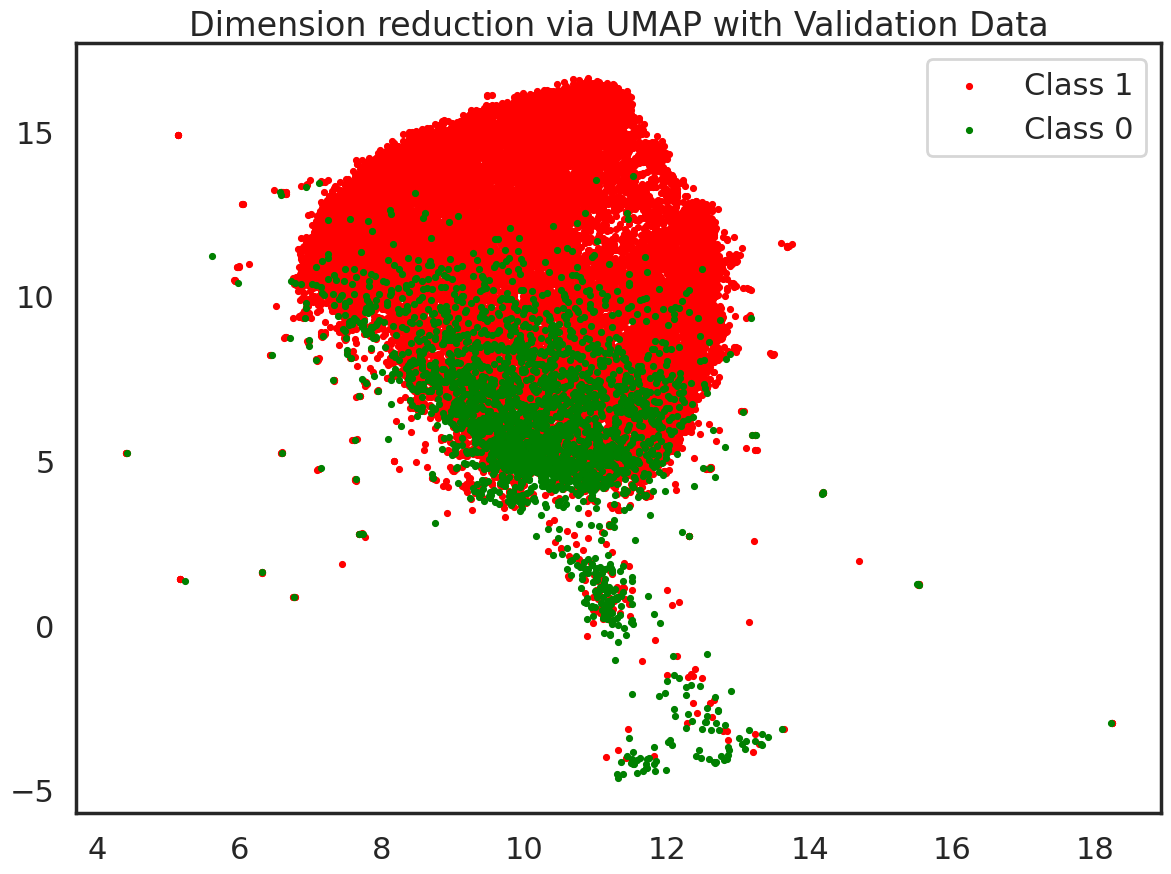

In [ ]:
ml_agent = MLModel('KNN')
#ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
#ml_agent.test(X_test, y_test)
X_projection = ml_agent.reduce_dimension(X_train, y_train, X_val, y_val)

In [ ]:
ml_agent = MLModel('KNN')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9086, Precision: 0.9097, Recall: 0.9971, F1: 0.9514 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 0.9217, Precision: 0.9213, Recall: 0.9981, F1: 0.9582
Best parameters: {'n_neighbors': 7}
Testing KNN ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Test Set Metrics - Accuracy: 0.9088, Precision: 0.9134, Recall: 0.9924, F1: 0.9513


In [ ]:
ml_agent = MLModel('RandomForest')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

RandomForest is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Best parameters: {'n_estimators': 100}
Testing RandomForest ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Test Set Metrics - Accuracy: 0.9235, Precision: 0.9293, Recall: 0.9900, F1: 0.9587


In [ ]:
ml_agent = MLModel('XGBoost')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

XGBoost is training ...
Validation Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Best parameters: {'learning_rate': 0.1, 'max_depth': 10}
Testing XGBoost ...
Test Set Metrics - Accuracy: 0.9310, Precision: 0.9415, Recall: 0.9842, F1: 0.9624


In [ ]:
ml_agent = MLModel('NaiveBayes')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.7568, Precision: 0.9778, Recall: 0.7460, F1: 0.8463 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 0.7480, Precision: 0.9754, Recall: 0.7381, F1: 0.8403
Best parameters: {}
Testing NaiveBayes ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Test Set Metrics - Accuracy: 0.8704, Precision: 0.9821, Recall: 0.8714, F1: 0.9234


In [ ]:
ml_agent = MLModel('DecisionTree')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9021, Precision: 0.9172, Recall: 0.9794, F1: 0.9473 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9064, Precision: 0.9236, Recall: 0.9765, F1: 0.9493
Best parameters: {'criterion': 'entropy', 'max_depth': 5}
Testing DecisionTree ...
Test Set Metrics - Accuracy: 0.9169, Precision: 0.9234, Recall: 0.9895, F1: 0.9553


In [ ]:
ml_agent = MLModel('LogisticRegression')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

LogisticRegression is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Metrics - Accuracy: 0.9288, Precision: 0.9436, Recall: 0.9791, F1: 0.9610 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9338, Precision: 0.9485, Recall: 0.9796, F1: 0.9638
Best parameters: {'C': 5}
Testing LogisticRegression ...
Test Set Metrics - Accuracy: 0.9341, Precision: 0.9492, Recall: 0.9789, F1: 0.9638


In [ ]:
ml_agent = MLModel('SVM')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

SVM is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 0.9391, Precision: 0.9465, Recall: 0.9880, F1: 0.9668 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 0.9460, Precision: 0.9541, Recall: 0.9874, F1: 0.9705
Best parameters: {'C': 5, 'kernel': 'linear'}
Testing SVM ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Test Set Metrics - Accuracy: 0.9373, Precision: 0.9516, Recall: 0.9799, F1: 0.9655


In [ ]:
"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/train_1/train_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/train_2/train_2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/LA/train_3/train_3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/LA/train_4/train_4.csv")
df5 = pd.read_csv("/content/drive/MyDrive/LA/train_5/train_5.csv")
df = pd.concat([df1, df2, df3, df4, df5], axis = 0)
"""

'\ndf1 = pd.read_csv("/content/drive/MyDrive/LA/train_1/train_1.csv")\ndf2 = pd.read_csv("/content/drive/MyDrive/LA/train_2/train_2.csv")\ndf3 = pd.read_csv("/content/drive/MyDrive/LA/train_3/train_3.csv")\ndf4 = pd.read_csv("/content/drive/MyDrive/LA/train_4/train_4.csv")\ndf5 = pd.read_csv("/content/drive/MyDrive/LA/train_5/train_5.csv")\ndf = pd.concat([df1, df2, df3, df4, df5], axis = 0)\n'

In [ ]:
"""
df.head(5)
"""

'\ndf.head(5)\n'

In [ ]:
"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/eval_1/eval_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/eval_2/eval_2.csv")
DF = pd.concat([df1, df2], axis = 0)
"""

'\ndf1 = pd.read_csv("/content/drive/MyDrive/LA/eval_1/eval_1.csv")\ndf2 = pd.read_csv("/content/drive/MyDrive/LA/eval_2/eval_2.csv")\nDF = pd.concat([df1, df2], axis = 0)\n'

In [ ]:
"""
DF.head(5)
"""

'\nDF.head(5)\n'

In [ ]:
"""
duplicates = df.duplicated(subset='file_name')
print(df[duplicates])
"""

"\nduplicates = df.duplicated(subset='file_name')\nprint(df[duplicates])\n"

In [ ]:
"""
duplicates = DF.duplicated(subset='file_name')
print(DF[duplicates])
"""

"\nduplicates = DF.duplicated(subset='file_name')\nprint(DF[duplicates])\n"

In [ ]:
"""
result = pd.merge(df, DF, on='file_name', how='inner')
"""

"\nresult = pd.merge(df, DF, on='file_name', how='inner')\n"

In [ ]:
#result.shape

In [ ]:
#df.to_csv("train.csv", index = False)

In [ ]:
#!ls